# Chapter 3 Factor investing and asset pricing anomalies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from zipfile import ZipFile 

## Loading the dataset

In [4]:
def load_dataset(
    start_date: str = '1999-12-31',
    end_date: str = '2019-01-01') -> np.ndarray:
    '''
    Parameters
    ----------
    start_date: str, start date of the stock dataset, default = '1999-12-31'
    end_date: str, end date of the stock dataset, default = '2019-01-01'
    
    Returns
    -------
    np.ndarray
    '''
    data_raw = pd.read_csv('data_ml.csv', index_col=0)
    data_raw.reset_index(inplace=True)
    del data_raw['index']

    idx_date = data_raw.index[(data_raw['date'] > start_date) & (data_raw['date'] < end_date)].to_list()
    data_ml = data_raw.iloc[idx_date]
    
    return data_ml

In [5]:
data_ml = load_dataset()

In [6]:
data_ml.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113


In [7]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268336 entries, 0 to 283379
Data columns (total 99 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   stock_id                        268336 non-null  int64  
 1   date                            268336 non-null  object 
 2   Advt_12M_Usd                    268336 non-null  float64
 3   Advt_3M_Usd                     268336 non-null  float64
 4   Advt_6M_Usd                     268336 non-null  float64
 5   Asset_Turnover                  268336 non-null  float64
 6   Bb_Yld                          268336 non-null  float64
 7   Bv                              268336 non-null  float64
 8   Capex_Ps_Cf                     268336 non-null  float64
 9   Capex_Sales                     268336 non-null  float64
 10  Cash_Div_Cf                     268336 non-null  float64
 11  Cash_Per_Share                  268336 non-null  float64
 12  Cf_Sales             

## Compute equally weighted portfolios (above and below the median)

In [9]:
def compute_equally_weighted_ptf(
    df: np.ndarray,
    sorting_feature: str = 'Mkt_Cap_12M_Usd',
    return_feature: str = 'R1M_Usd',
    is_visualise: bool = False) -> np.ndarray:
    '''
    Parameters
    ----------
    df: dataset, 
    sorting_feature: str, optional, default is Mkt_Cap_12M_Usd
    return_feature: str, optional, default is R1M_Usd
    is_visualise: bool
    
    Returns
    -------
    np.ndarray
    '''
    assert 'date' in df.columns
    assert sorting_feature in df.columns
    assert return_feature in df.columns
    
    df_median = df[['date', sorting_feature]].groupby(['date']).median().reset_index()
    df_median.rename(columns = {sorting_feature: sorting_feature + '_median'}, inplace = True)

    df = pd.merge(data_ml[['date', sorting_feature, return_feature]],
                  df_median,
                  how = 'left',
                  on = ['date'])
    df = df.groupby(
        [pd.to_datetime(df['date']).dt.year,
         np.where(df[sorting_feature] > df[sorting_feature + '_median'], 'above-median', 'below-median')])[return_feature].mean().reset_index()
    df.rename(columns = {'level_1': sorting_feature + '_sort'}, inplace = True)

    df = df.pivot(index='date', columns = sorting_feature + '_sort', values = return_feature)

    if is_visualise == True:
        df.plot.bar(figsize=(10, 6))
        plt.ylabel('Average ' + return_feature)
        plt.xlabel('date')
        plt.title('Equally weighted portfolios by sorting ' + sorting_feature)
        
    return df

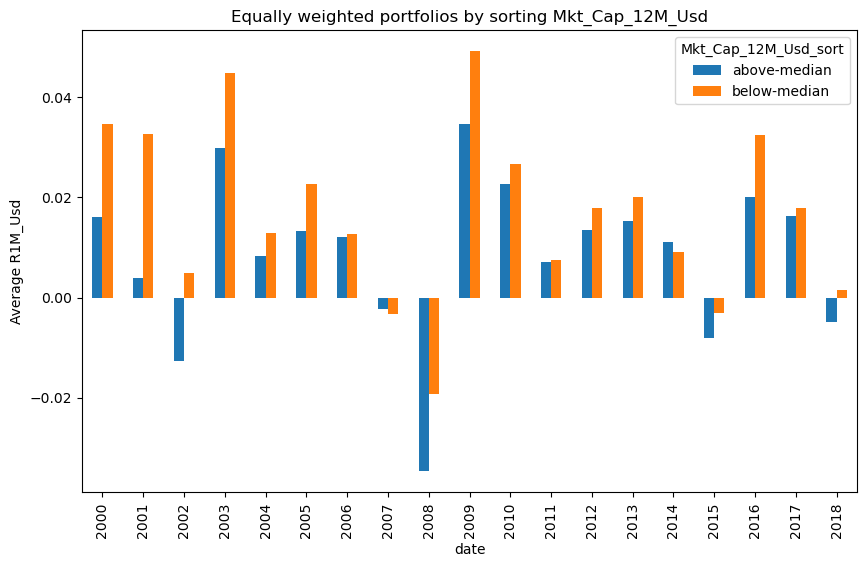

In [10]:
ptf_1 = compute_equally_weighted_ptf(data_ml, is_visualise = True)

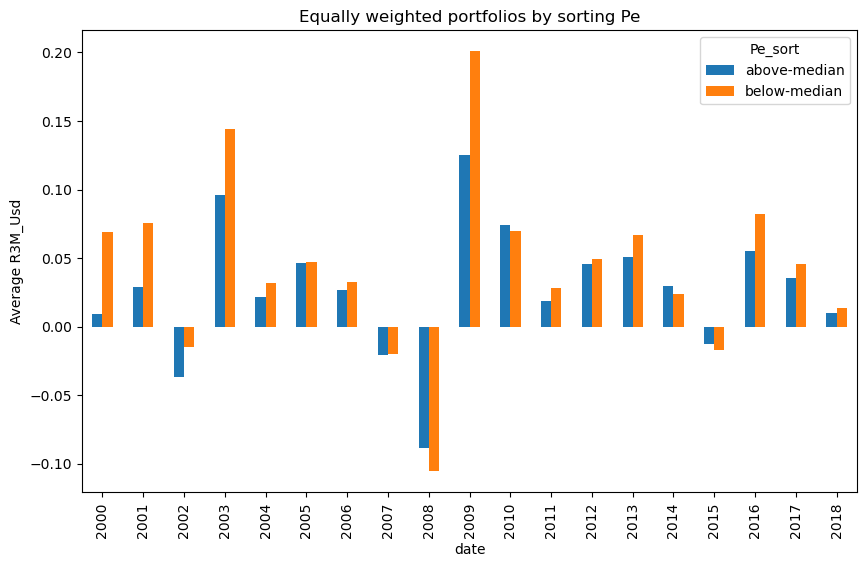

In [11]:
ptf_2 = compute_equally_weighted_ptf(data_ml, 'Pe', 'R3M_Usd', is_visualise = True)

Questions:
1. Can we further generalize the function into multiple factors?
2. Can we futher generalize the function such that the portfolio is not necessarily equally weighted?

## Import data from Ken French's data library

In [14]:
def import_FF_factors_dataset(
    start_date_yyyymm: str = '196307',
    end_date_yyyymm: str = '202003') -> np.ndarray:
    '''
    Parameters
    ----------
    start_date_yyyymm: str, start date of the factor dataset in yyyymm format, default = '196307'
    end_date_yyyymm: str, end date of the factor dataset in yyyymm format, default = '202003'
    
    Returns
    -------
    np.ndarray
    '''
    ff_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp'
    ff_url += '/F-F_Research_Data_5_Factors_2x3_CSV.zip'
    
    urllib.request.urlretrieve(ff_url, 'factors.zip')
    with ZipFile('factors.zip', 'r') as zObject: 
        zObject.extractall()
    df_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', header = 2, sep = ',', quotechar = '"')
    
    df_ff.rename(columns = {'Unnamed: 0': 'date', 'Mkt-RF': 'MKT_RF'}, inplace = True)
    df_ff = df_ff[df_ff.index < df_ff[df_ff['date'] == ' Annual Factors: January-December '].index[0]]
    
    selected_columns = list(df_ff.columns)[1:]
    df_ff[selected_columns] = df_ff[selected_columns].astype('float') / 100
    idx_ff = df_ff.index[(df_ff['date'] >= start_date_yyyymm) & (df_ff['date'] <= end_date_yyyymm)]
    
    FF_factors = df_ff.iloc[idx_ff]
    FF_factors['year'] = FF_factors.date.astype(str).str[:4]
    
    return FF_factors

In [15]:
FF_factors = import_FF_factors_dataset()

/var/folders/jz/_62zm7jn3y754w_n7gcp4v3m0000gn/T/ipykernel_14503/1765758157.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_factors['year'] = FF_factors.date.astype(str).str[:4]


In [16]:
FF_factors.head()

,date,MKT_RF,SMB,HML,RMW,CMA,RF,year
0,196307,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,1963
1,196308,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,1963
2,196309,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,1963
3,196310,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,1963
4,196311,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,1963


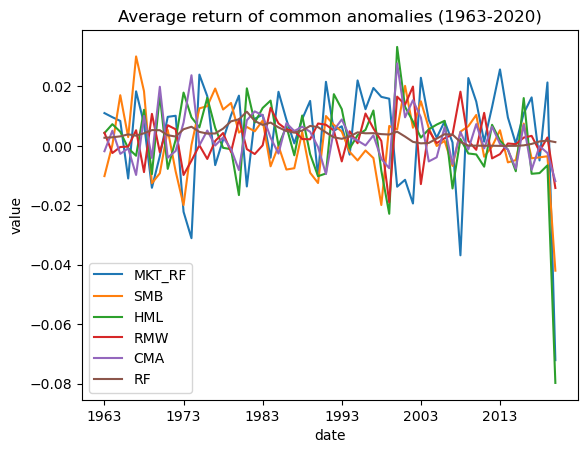

In [17]:
FF_factors.iloc[:,1:7].groupby(FF_factors['year']).mean().plot()
plt.ylabel('value')
plt.xlabel('date')
plt.title('Average return of common anomalies (1963-2020)')
plt.show()

/var/folders/jz/_62zm7jn3y754w_n7gcp4v3m0000gn/T/ipykernel_14503/1765758157.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_factors['year'] = FF_factors.date.astype(str).str[:4]


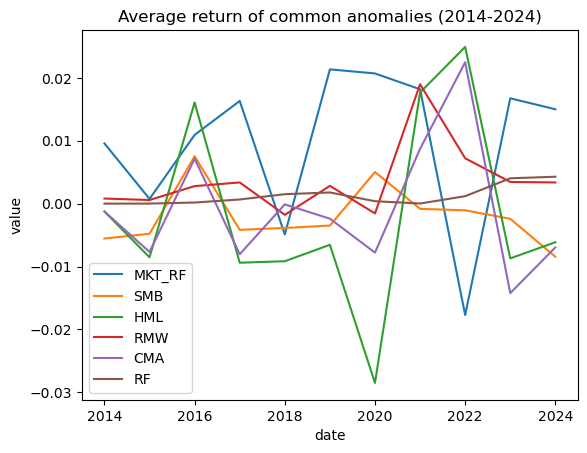

In [18]:
FF_factors_new = import_FF_factors_dataset('201401', '202412')
FF_factors_new.iloc[:,1:7].groupby(FF_factors_new['year']).mean().plot()
plt.ylabel('value')
plt.xlabel('date')
plt.title('Average return of common anomalies (2014-2024)')
plt.show()

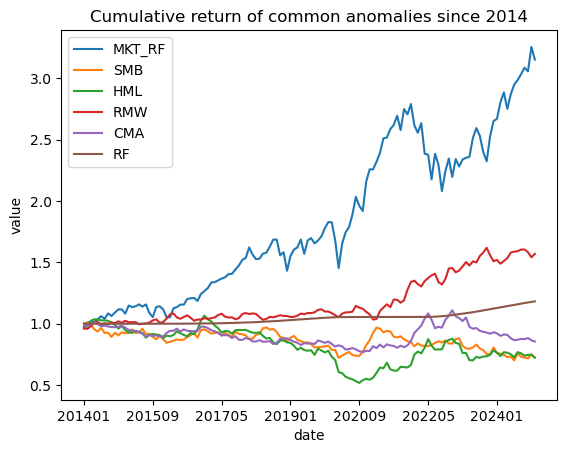

In [20]:
simulated_ptf_return = FF_factors_new.copy()
simulated_ptf_return[list(FF_factors_new.columns)[1:7]] = simulated_ptf_return[list(FF_factors_new.columns)[1:7]] + 1
simulated_ptf_return[list(FF_factors_new.columns)[1:7]] = simulated_ptf_return[list(simulated_ptf_return.columns)[1:7]].cumprod()
simulated_ptf_return.iloc[:,1:7].groupby(simulated_ptf_return['date']).mean().plot()
plt.ylabel('value')
plt.xlabel('date')
plt.title('Cumulative return of common anomalies since 2014')
plt.show()

## Interesting ideas to explore

1. An Evaluation of Alternative Multiple Testing Methods for Finance Applications: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3480087
2. Complex sorting algo 1 - Deep Learning in Characteristics-Sorted Factor Models: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3243683
3. Complex sorting algo 2 - Forest Through the Trees: Building Cross-Sections of Stock Returns: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3493458
4. Bayesian Solutions for the Factor Zoo: We Just Ran Two Quadrillion Models - https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3481736